In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

import emcee

# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

In [2]:
t = Table.read('line_fitting.csv')
t.remove_column('col0')
t

x,y,y_err
float64,float64,float64
0.5967789660956835,8.112571477412992,0.16031433299516187
0.9210493994507518,3.5281507535035828,0.5131704002534166
1.1561839507929572,4.810233556268032,0.40153006420546367
1.7545175614749253,0.8923816409204828,0.3725340032332325
1.8249173045349998,3.1329519539885804,0.2713819168871542
2.268514535642031,3.533380342240384,0.2520603945135921
...,...,...
7.379954057320357,-3.7206188619753884,0.4812739068927169
8.494317940777895,-4.859427930794116,0.39658845828111056


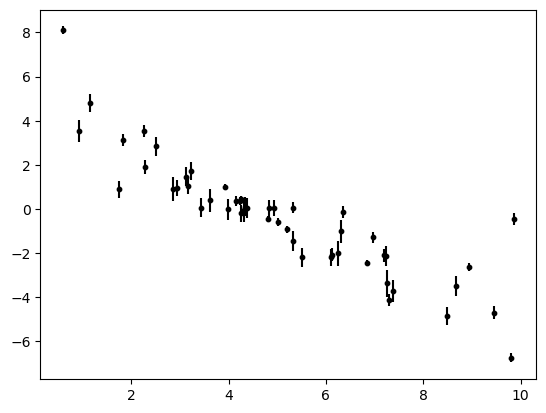

In [3]:
plt.scatter(t['x'], t['y'], s=10, color='black')
plt.errorbar(t['x'], t['y'], yerr=t['y_err'], linestyle='None', color='black')
plt.show()

In [4]:
x = np.array(t['x'].value)
y = np.array(t['y'].value)
y_err = np.array(t['y_err'].value)

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

## a) emcee

In [61]:
def lnlikelihood(theta, x, y, y_unc):
    m, b = theta
    model_preds = m*x + b
    lnl = -1 * np.sum(((y - model_preds)**2)/(2*y_unc**2)) # complete
    return lnl

def lnprior(theta):
    m, b = theta
    if -100 <= m <= 0 and -100 <= b <= 100:
        lnp = np.log(1/100) + np.log(1/200)
    else:
        lnp = -np.inf
    return lnp

def lnposterior(theta, x, y, y_unc):
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, x, y, y_unc)
    lnpost = lnl + lnp 
    return lnpost

In [69]:
nwalkers = 10
sampler = emcee.EnsembleSampler(nwalkers, 2, lnposterior, args=[x, y, y_err])

p0 = np.vstack([np.random.uniform(-10, 0, size=nwalkers), np.random.uniform(0, 10, size=nwalkers)]).T
print(p0)

nsteps = 10000
sampler.run_mcmc(p0, nsteps)

[[-2.28698124  8.13124959]
 [-5.21719884  9.64366513]
 [-0.87260365  2.52163769]
 [-1.85527323  7.15151294]
 [-4.64728861  0.23170171]
 [-1.82000558  4.91957409]
 [-8.55392962  7.83267712]
 [-7.24440667  2.13479826]
 [-4.71650663  0.18133554]
 [-1.8215965   5.91098166]]


State([[-1.08182042  5.35796372]
 [-1.07549026  5.25512357]
 [-1.10874818  5.40424363]
 [-1.10747594  5.45256965]
 [-1.08707447  5.32916535]
 [-1.1186481   5.49176818]
 [-1.11225545  5.49095644]
 [-1.0778097   5.32002497]
 [-1.09416565  5.39207742]
 [-1.12433087  5.54080581]], log_prob=[-626.76312532 -627.57174544 -626.84132276 -625.49106222 -626.22529055
 -626.0643684  -625.61204383 -626.84048494 -625.64667579 -626.24163763], blobs=None, random_state=('MT19937', array([3772345393, 1156340816, 1362195433, 2511042790,  846741673,
       3686400152, 3860167633, 2276851339, 1847504190, 1466630326,
       1669812721,  189142521, 1305611823, 2716091863, 1384582654,
       4266941892,  560128723,  263289497,  261893738, 3775203636,
       1496427370, 2184863259, 3627730824, 4214830482,   91091252,
       4294910512, 1770518303,  445384183, 3732245961, 1004942046,
       2376453847, 3637294083, 3519607991, 2732160189, 1819201889,
       1297616960, 1735052490, 3543760200, 3124372938, 10616096

In [70]:
samples = sampler.get_chain()
print(samples.shape)

(10000, 10, 2)


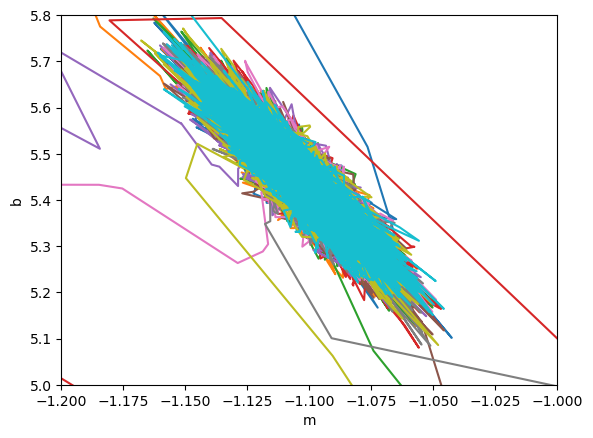

In [71]:
%matplotlib inline

for n in range(nwalkers):
    plt.plot(samples[:,n,0], samples[:,n,1])
plt.xlim(-1.2, -1)
plt.ylim(5, 5.8)
plt.xlabel('m')
plt.ylabel('b')
plt.show()

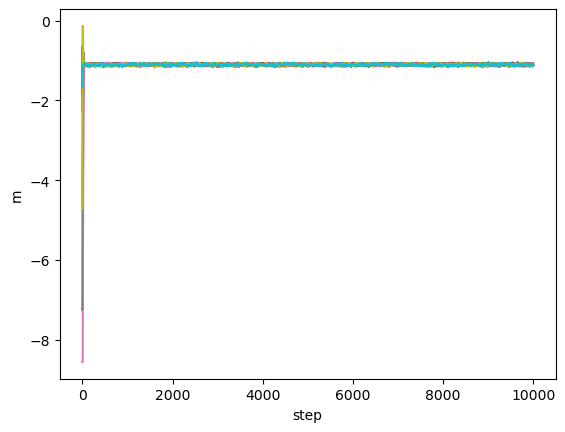

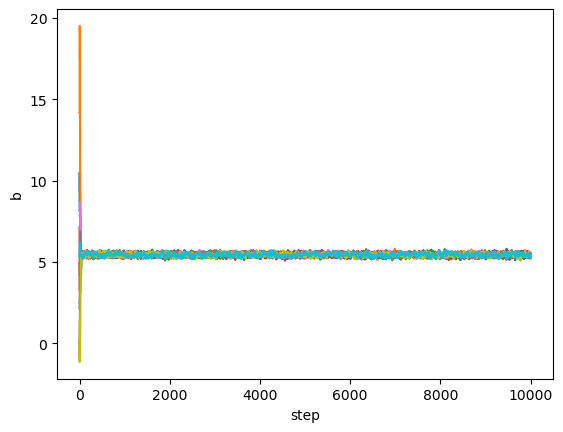

In [72]:
%matplotlib inline

for n in range(nwalkers):
    plt.plot(samples[:,n,0])
plt.xlabel('step')
plt.ylabel('m')
plt.show()

for n in range(nwalkers):
    plt.plot(samples[:,n,1])
plt.xlabel('step')
plt.ylabel('b')
plt.show()

In [74]:
values50 = {}
for n, param in enumerate(['m', 'b']):
    values50[param] = np.median(samples[500:,:,n])
    print(f'50th percentile for {param}: {np.median(samples[500:,:,n])}')

50th percentile for m: -1.1037148112769974
50th percentile for b: 5.43980814416496


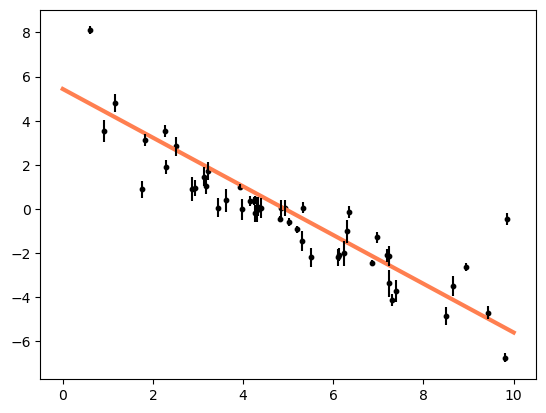

In [78]:
xs = np.linspace(0, 10, 100)
plt.scatter(t['x'], t['y'], s=10, color='black')
plt.plot(xs, values50['m']*xs + values50['b'], color='coral', linewidth=3)
plt.errorbar(t['x'], t['y'], yerr=t['y_err'], linestyle='None', color='black')
plt.show()

## c) dynesty

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.